In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, re

from astropy.table import Table, join, Column

from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
from thejoker import compute_likelihoods, likelihood

import astropy.units as u
import corner

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
ls ../results/

results_rvs.png     results_video.hdf5


In [59]:
fname = '../data/rvs_feb.csv'
fname_old = '../data/rvs_new.csv'
data = Table.read(fname)
data_old = Table.read(fname_old)

In [60]:
data

JD,RV_wobble,RV_err_wobble,RV_pipeline,RV_err_pipeline
float64,float64,float64,float64,float64
2458478.77385868,5.27,52.9293,347.6367,38.1361
2458475.75494602,13.5225,423.7135,2748.6556,109.093
2458483.76824614,1.8312,28.7477,1018.7868,32.3034
2458484.7715361,-1.7434,49.4788,488.0322,68.1124
2458488.75504513,-9.8307,8.9256,-3162.77,32.8066
2458487.75295055,-6.7751,14.9931,-1433.1261,34.264
2458486.7020907,-3.2811,15.9122,-1096.3859,28.2733
2458489.77033405,-10.9319,10.1043,1325.9306,53.8067
2458479.77133004,-8.9137,38.5446,491.4713,32.6418


In [61]:
t = data['JD']
rv = data['RV_wobble'] * u.m/u.s
err =  data['RV_err_wobble'] * u.m/u.s
err[~np.isfinite(err)] = 300 * u.m/u.s
data = RVData(t=t, rv=rv, stddev=err)

t_old = data_old['JD']
rv_old = data_old['RV_wobble'] * u.m/u.s
err_old =  data_old['RV_err_wobble'] * u.m/u.s
data_old = RVData(t=t_old, rv=rv_old, stddev=err_old)


In [62]:
data.stddev

<Quantity [ 47.482 , 423.7135,  52.9293,  38.5446,  71.8103,  45.7666,
            28.7477,  49.4788,  15.9122,  14.9931,   8.9256,  10.1043,
             2.6561, 297.0718, 300.    ] m / s>

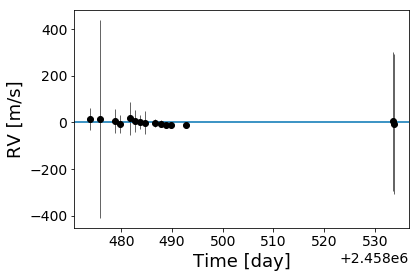

In [63]:
ax = data.plot() # doctest: +SKIP
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
plt.axhline(0)

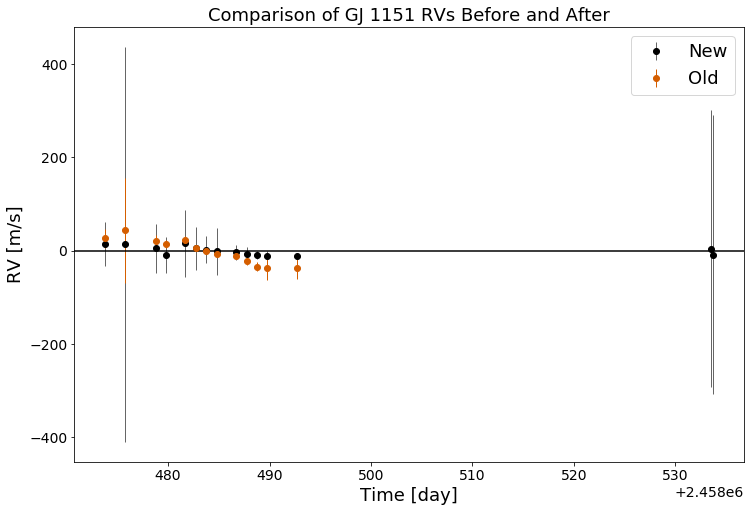

In [79]:
f = plt.figure(figsize=(12.0,8.0))

ax = data.plot(label='New') # doctest: +SKIP
data_old.plot(color=colours[2],ecolor=colours[2],label='Old')
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
plt.axhline(0,color='k')
plt.legend(fontsize=18)
plt.title('Comparison of GJ 1151 RVs Before and After',fontsize=18)
plt.savefig('before_and_after.png',bbox_inches='tight')

In [18]:
np.median(err)

<Quantity 45.7666 m / s>

In [19]:
params = JokerParams(P_min=0.5*u.day, P_max=200*u.day)

In [20]:
params_trend = JokerParams(P_min=1*u.day, P_max=15*u.day,poly_trend=2)

In [21]:
# do trend
joker = TheJoker(params_trend)

In [25]:
2**14

16384

In [26]:
%%time
samples_trend = joker.rejection_sample(data, n_prior_samples=16384)

INFO: 9520 good samples after rejection sampling [thejoker.sampler.sampler]
CPU times: user 8.86 s, sys: 391 ms, total: 9.26 s
Wall time: 6.42 s


CPU times: user 2.38 s, sys: 29.8 ms, total: 2.41 s
Wall time: 2.41 s


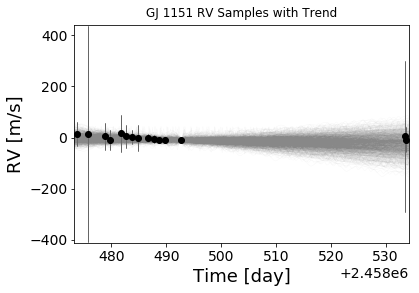

In [28]:
%%time
t_grid = np.linspace(t.min()-0.5, t.max()+0.5, 1024)

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_trend[:1024], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples with Trend',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.max()+0.5)
ax.set_ylim((rv-err).min().value-2.,(rv+err).max().value+2.)

# plt.savefig('gj1151b_samples_trend.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples_trend.pdf',bbox_inches='tight')


In [30]:
test = samples_trend.copy()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.01, 'Constraints on GJ 1151 b K')

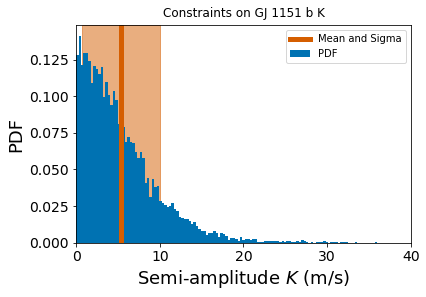

In [31]:
plt.xlim(0,40)
plt.axvline(test['K'].value.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(test['K'].value.mean()-test['K'].value.std(),test['K'].value.mean()+test['K'].value.std(),color=colours[2],alpha=0.5)
h = plt.hist(test['K'].value,bins=200,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'Semi-amplitude $K$ (m/s)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b K',y=1.01)
# plt.savefig('gj1151b_posterior.png',bbox_inches='tight')
# plt.savefig('gj1151b_posterior.pdf',bbox_inches='tight')

### Now let's calculate the planet's mass

In [32]:
Ps = samples_trend['P'].to(u.d).value

eccs = samples_trend['e'].value

Ks = samples_trend['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 


In [33]:
print(Mstar-dMstar/2.,Mstar+dMstar/2.)

0.1545 0.17950000000000002


In [34]:
Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

In [35]:
print('Msini: %.2f +- %.2f' % (np.mean(Msini), np.std(Msini)),'M_Earth')

Msini: 3.95 +- 3.56 M_Earth


In [36]:
print(np.percentile(Msini,99))

16.28985164538274


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


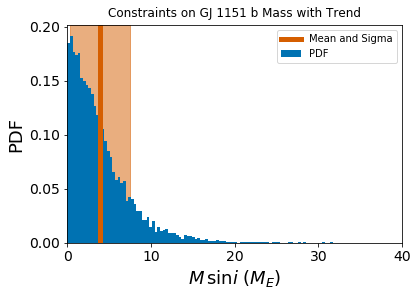

In [37]:
plt.xlim(0,40.)
plt.axvline(Msini.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(Msini.mean()-Msini.std(),Msini.mean()+Msini.std(),color=colours[2],alpha=0.5)
h = plt.hist(Msini,bins=100,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'$M\, \sin{i}$ ($M_E$)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b Mass with Trend',y=1.01)
plt.savefig('gj1151b_mass_trend.png',bbox_inches='tight')
plt.savefig('gj1151b_mass_trend.pdf',bbox_inches='tight')

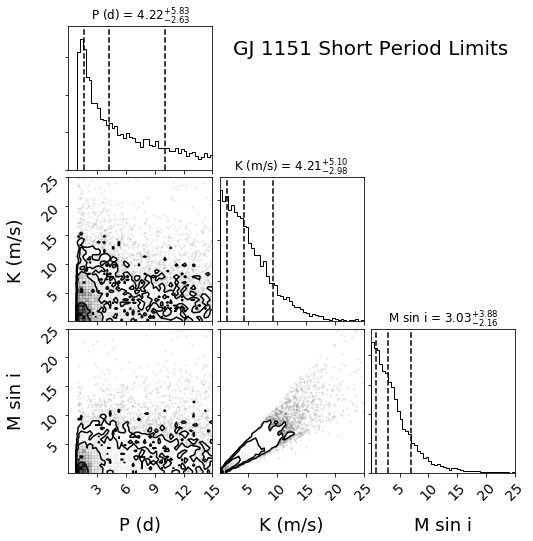

In [38]:
dummy = np.array([samples_trend['P'].value,samples_trend['K'].value,Msini]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)','M sin i'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,15),(0,25),(0,25)));
figure.gca().annotate("GJ 1151 Short Period Limits",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

# plt.savefig('cornerplot_km_trend.png',bbox_inches='tight')
# plt.savefig('cornerplot_km_trend.pdf',bbox_inches='tight')


In [48]:
# do without trend
params = JokerParams(P_min=0.5*u.day, P_max=200*u.day)
params = JokerParams(P_min=0.9*u.day, P_max=1.1*u.day)
joker = TheJoker(params)
samples_long = joker.rejection_sample(data, n_prior_samples=2**14)

INFO:thejoker:6948 good samples after rejection sampling


INFO: 6948 good samples after rejection sampling [thejoker.sampler.sampler]


CPU times: user 4.06 s, sys: 37.1 ms, total: 4.1 s
Wall time: 4.09 s


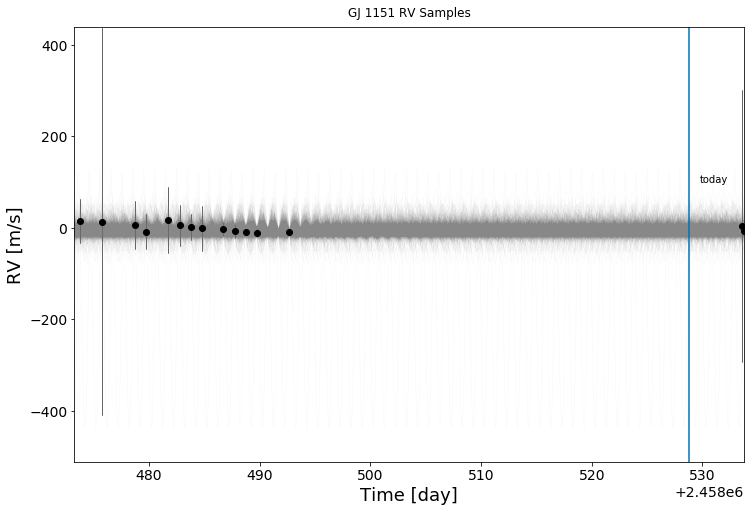

In [80]:
%%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.min()-0.5, t.min()+60., 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_long[:2048], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.min()+60.)
ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
plt.axvline(t.min()+55)
plt.text(t.min()+56,100,'today')
# plt.savefig('gj1151b_samples_long.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


CPU times: user 2.16 s, sys: 33.5 ms, total: 2.2 s
Wall time: 2.2 s


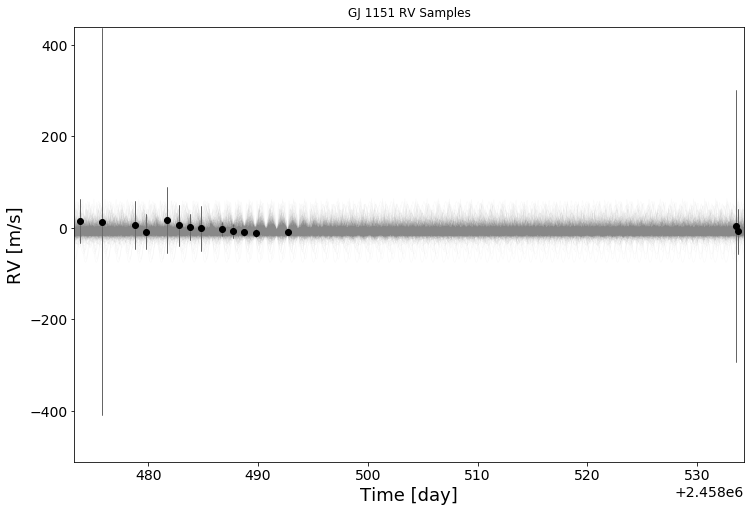

In [50]:
%%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.min()-0.5, t.max()+0.5, 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_long[:1024], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.max()+0.5)
ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
# plt.savefig('gj1151b_samples.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


In [82]:
Ps = samples_long['P'].to(u.d).value

eccs = samples_long['e'].value

Ks = samples_long['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 

Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

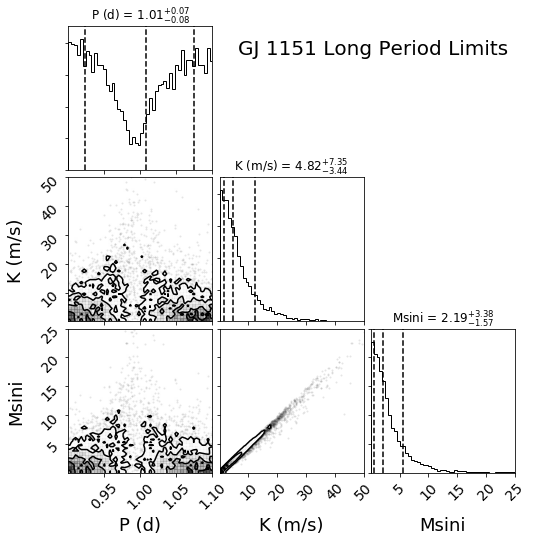

In [85]:
dummy = np.array([samples_long['P'].value,samples_long['K'].value,Msini]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)',r'Msini'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0.9,1.1),(0,50),(0,25)));
figure.gca().annotate("GJ 1151 Long Period Limits",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

plt.savefig('cornerplot_km_long.png',bbox_inches='tight')
plt.savefig('cornerplot_km_long.pdf',bbox_inches='tight')


In [45]:
short = samples_long['P'].value<5
# h = plt.hist(samples_long['P'][short])

Text(-25, -40, 'GJ 1151 Short Period Alias')

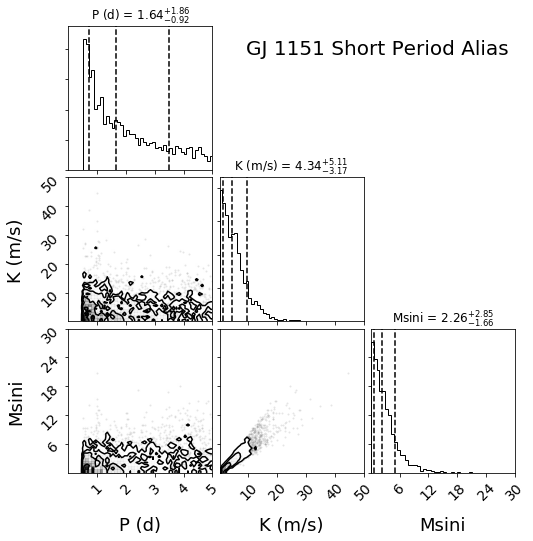

In [46]:
dummy = np.array([samples_long['P'].value[short],samples_long['K'].value[short],Msini[short]]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)',r'Msini'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,5),(0,50),(0,30)));
figure.gca().annotate("GJ 1151 Short Period Alias",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

# plt.savefig('cornerplot_km_vshort.png',bbox_inches='tight')
# plt.savefig('cornerplot_km_long.pdf',bbox_inches='tight')


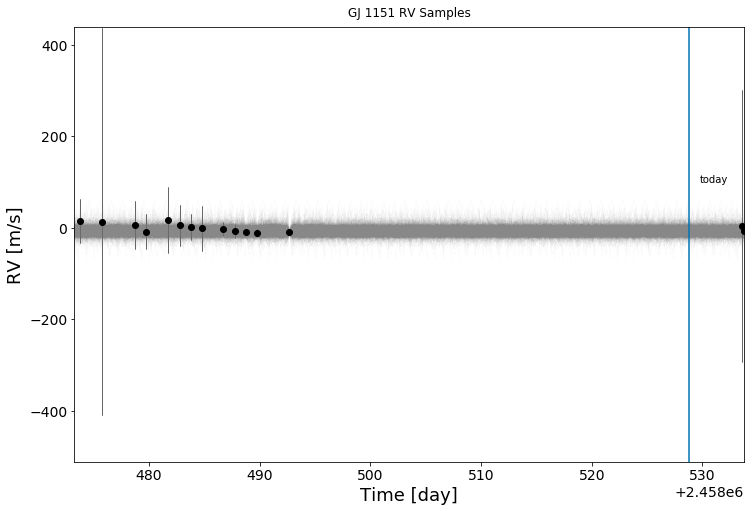

In [47]:
# %%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.min()-0.5, t.min()+60., 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
# data_old.plot(color=colours[2])
plot_rv_curves(samples_long[short], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.min()+60.)
ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
plt.axvline(t.min()+55)
plt.text(t.min()+56,100,'today')

plt.savefig('gj1151b_samples_short_predict.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


### check time sampling

In [ ]:
print(['%.2f' % s for s in ((data.t-data.t0).value % 1.)*100])

### Try with TRES data as well

In [ ]:
tres_t = [2457764.977731,2458110.061319,2458471.011988,2458475.895541] 
tres_rv = [0.0839,  0.1237,0.0630,0.0195] 
tres_rv_err = [0.0643,0.0502,0.0589,0.0472]

In [ ]:
fname = '../data/rvs_new.csv'
data = Table.read(fname)

t = np.concatenate([np.array(tres_t),data['JD'].data])*u.day
rv = np.concatenate([np.array(tres_rv)*1000.,data['RV_wobble'].data])* u.m/u.s
err = np.concatenate([np.array(tres_rv_err)*1000.,data['RV_err_wobble'].data])* u.m/u.s
data = RVData(t=t, rv=rv, stddev=err)


In [ ]:
joker = TheJoker(params)
samples = joker.rejection_sample(data, n_prior_samples=16384*8)

In [ ]:
# %%time
fig = plt.figure(figsize=(12.0,8.0))
t_grid = np.linspace(t.value.min()-0.5, t.value.max()+0.5, 1024) # 55 days since 10 dec

ax = data.plot() # doctest: +SKIP
data_old.plot(color=colours[2])
plot_rv_curves(samples[:2048], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
ax.set_xlim(t.value.min()-0.5, t.value.max()+0.5)
ax.set_ylim((rv-err).min().value-2.-100,(rv+err).max().value+2.)
# plt.axvline(t.min()+55)
# plt.text(t.min()+56,100,'today')
plt.savefig('gj1151b_samples_tres.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
# plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


In [ ]:
Ps = samples['P'].to(u.d).value

eccs = samples['e'].value

Ks = samples['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 

Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

In [ ]:
dummy = np.array([samples['P'].value,samples['K'].value,Msini]).T
figure = corner.corner(dummy,labels=['P (d)','K (m/s)',r'Msini'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,200),(0,300),(0,1200)));
figure.gca().annotate("GJ 1151 Long Period Limits",fontsize=20,
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-25, -40), textcoords="offset points",
                      ha="right", va="top")

plt.savefig('cornerplot_km_tres.png',bbox_inches='tight')


In [ ]:
samples_trend